In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
import scikitplot as skplt
from sklearn import preprocessing
import time
from scipy import stats
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox

In [2]:
raw_data = pd.read_csv('paysim.csv')

In [3]:
print(raw_data.describe())
print(raw_data.head())

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [4]:
#rename columns
df = raw_data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [5]:
#modification for step feature
df['step'] = df['step'] % 24

In [6]:
#drop feature irrelevant
df.drop(['nameOrig', 'nameDest'], axis = 1, inplace = True)

In [7]:
#get feature values 
df = df[(df['type'] == 'CASH_OUT') | (df['type'] == 'TRANSFER')]

In [8]:
#one hot encoding feature type
from sklearn.preprocessing import OrdinalEncoder
typeTrans = [['CASH_OUT'] , ['TRANSFER']]
oencoder = OrdinalEncoder()
oencoder.fit(typeTrans)
df['type_en'] = oencoder.transform(df['type'].values.reshape(-1,1))

In [9]:
df

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,type_en
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,0,1.0
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,0,0.0
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0,0,0.0
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0,0,1.0
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...
6362615,23,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,0,0.0
6362616,23,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,0,1.0
6362617,23,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,0,0.0
6362618,23,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,0,1.0


In [10]:
df.drop(['type'], axis = 1, inplace = True)

In [11]:
df.head()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,type_en
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1.0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0,0.0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0,0.0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1.0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1.0


In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [13]:
test = SelectKBest(score_func = f_classif, k= 3)

In [19]:
y = df['isFraud']
X = df.drop(['isFraud', 'oldBalanceDest', 'newBalanceDest', 'isFlaggedFraud', 'amount', 'oldBalanceOrig', 'newBalanceOrig'], axis = 1)
#X = df.drop(['isFraud'], axis = 1)

In [20]:
X

,step,type_en
2,1,1.0
3,1,0.0
15,1,0.0
19,1,1.0
24,1,1.0
...,...,...
6362615,23,0.0
6362616,23,1.0
6362617,23,0.0
6362618,23,1.0


In [21]:
fit = test.fit(df.drop(['isFraud'], axis = 1), df['isFraud'])
print(fit.scores_)
features = fit.transform(df.drop(['isFraud'], axis = 1))
print(features[0:5,:])

[7.29001755e+03 1.39016379e+04 3.80694276e+05 1.12365491e+04
 6.20175363e+02 2.23308306e+02 5.39161938e+03 4.98958834e+03]
[[1.8100000e+02 1.8100000e+02 0.0000000e+00]
 [1.8100000e+02 1.8100000e+02 0.0000000e+00]
 [2.2913394e+05 1.5325000e+04 0.0000000e+00]
 [2.1531030e+05 7.0500000e+02 0.0000000e+00]
 [3.1168589e+05 1.0835000e+04 0.0000000e+00]]


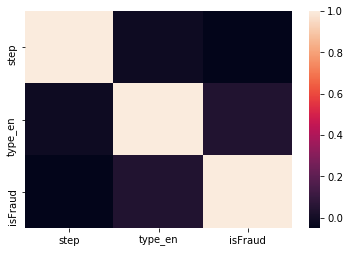

In [22]:
sns.heatmap(pd.concat([X, y], axis = 1).corr())

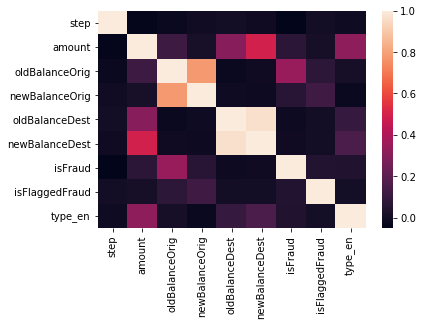

In [17]:
sns.heatmap(df.corr())

In [23]:
X_train_res, X_test, y_train_res, y_test = train_test_split(X, y, random_state = 123, test_size = 0.1)

In [24]:
# define resampling
over = SMOTE(random_state = 123, sampling_strategy = 0.008)
under = RandomUnderSampler(random_state = 123, sampling_strategy = 0.5)
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])
#pipeline = Pipeline(steps=[('o', over)])

In [25]:
# fit and apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X_train_res, y_train_res)
print(np.unique(y_resampled, return_counts = True))
pd.DataFrame(X_resampled)

(array([0, 1], dtype=int64), array([39774, 19887], dtype=int64))


,step,type_en
0,9,0.0
1,19,0.0
2,15,0.0
3,9,0.0
4,9,0.0
...,...,...
59656,1,1.0
59657,15,0.0
59658,1,1.0
59659,14,1.0


In [29]:
scoring = {'accuracy' : 'accuracy', 'precision' : 'precision', 'recall' : 'recall', 'f1' : 'f1', 'auc' : 'roc_auc' , 'specificity' : make_scorer(recall_score, pos_label=0)}

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold
cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state = 123)

In [32]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

imba_pipeline = make_pipeline(SMOTE(random_state = 123, sampling_strategy = 0.008), RandomUnderSampler(random_state = 123, sampling_strategy = 0.5), CategoricalNB())
hasil_awal = cross_validate(imba_pipeline, X_train_res, y_train_res, scoring=scoring, cv=cv_method)

In [33]:
hasil_awal_df = pd.concat([pd.DataFrame(hasil_awal["test_accuracy"], columns=["accuracy"]), pd.DataFrame(hasil_awal["test_precision"], columns=["precision"]), pd.DataFrame(hasil_awal["test_recall"], columns=["recall"]), pd.DataFrame(hasil_awal["test_f1"], columns=["f1"]), pd.DataFrame(hasil_awal["test_auc"], columns=["auc"]), pd.DataFrame(hasil_awal["test_specificity"], columns=["specificity"])],axis=1)

In [34]:
hasil_awal_df['fpr'] = 1- hasil_awal_df['specificity']

In [35]:
hasil_awal_df.describe()

,accuracy,precision,recall,f1,auc,specificity,fpr
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.957756,0.031967,0.453930,0.059727,0.808760,0.959250,0.040750
std,0.000443,0.001102,0.014996,0.002048,0.008453,0.000438,0.000438
min,0.956745,0.030141,0.428765,0.056323,0.796372,0.958198,0.039920
25%,0.957519,0.031159,0.441316,0.058209,0.802125,0.959041,0.040455
50%,0.957752,0.031975,0.454545,0.059794,0.807348,0.959240,0.040760
75%,0.958082,0.032879,0.464043,0.061409,0.813730,0.959545,0.040959
max,0.958602,0.034344,0.487110,0.064164,0.824546,0.960080,0.041802


In [41]:
gnb = CategoricalNB().fit(X_resampled, y_resampled)
pred1 = gnb.predict(X_resampled)
print('accuracy score = ', accuracy_score(y_resampled, pred1))
print('precision score = ', precision_score(y_resampled, pred1))
print('recall score = ', recall_score(y_resampled, pred1))
print('f1 score = ', f1_score(y_resampled, pred1))
print('roc auc score = ', roc_auc_score(y_resampled, pred1))
cm = confusion_matrix(y_resampled, pred1)
specificity1 = cm[0,0]/(cm[0,1]+cm[0,0])
print('Specificity : ', specificity1)

accuracy score =  0.7918573272321953
precision score =  0.8497050285607266
recall score =  0.4562779705335144
f1 score =  0.5937315971995027
roc auc score =  0.707962488057525
Specificity :  0.9596470055815357


In [38]:
pd.DataFrame(cm)

,0,1
0,33018,6756
1,7892,11995


In [40]:
time_start = time.time()
np.random.seed(999)

#gb = GaussianNB()

params = {"classifier__class_prior": [None, [0.5,0.5], [0.6,0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]],
              "classifier__alpha": np.linspace(0, 1),
                "classifier__fit_prior" : [True, False]}

#params_NB = {'priors': [None, [0.5,0.5], [0.6,0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]], 'var_smoothing':np.logspace(0, -9)}
imba_pipeline2 = Pipeline([('smote', SMOTE(random_state = 123, sampling_strategy = 0.008)), 
                           ('under', RandomUnderSampler(random_state = 123, sampling_strategy = 0.5)),
                           ('classifier', CategoricalNB())])


gs_NB2 = RandomizedSearchCV(imba_pipeline2, 
                     param_distributions=params, 
                     cv=cv_method,
                     n_iter = 100,
                     verbose=1, 
                     scoring=scoring, refit = 'recall')


#X_resampled, y_resampled = pipeline.fit_resample(X_train_res, y_train_res)
#X_transformed = PowerTransformer().fit_transform(X_resampled)

gs_NB2.fit(X_train_res, y_train_res)
time_elapsed = (time.time() - time_start)
print(time_elapsed)

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\naive_bayes.py:506: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\naive_bayes.py:506: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\naive_bayes.py:506: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\naive_bayes.py:506: UserWarning: alpha too small will result in numeric errors, setting alpha

17080.728505373


In [42]:
result2 = pd.concat([pd.DataFrame(gs_NB2.cv_results_["params"]),pd.DataFrame(gs_NB2.cv_results_["mean_test_accuracy"], columns=["mean_accuracy"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_precision"], columns=["mean_precision"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_recall"], columns=["mean_recall"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_f1"], columns=["mean_f1"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_auc"], columns=["mean_auc"]), pd.DataFrame(gs_NB2.cv_results_["mean_test_specificity"], columns=["mean_specificity"])],axis=1)

In [43]:
result2['mean_fpr'] = 1 - result2['mean_specificity']

In [44]:
print(gs_NB2.best_params_)
result2.describe()

{'classifier__fit_prior': True, 'classifier__class_prior': [0.5, 0.5], 'classifier__alpha': 0.9591836734693877}


,classifier__alpha,mean_accuracy,mean_precision,mean_recall,mean_f1,mean_auc,mean_specificity,mean_fpr
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.541020,0.914608,0.040860,0.503502,0.068822,0.808765,0.915827,0.084173
std,0.297253,0.079924,0.035887,0.134454,0.051372,0.000002,0.080554,0.080554
min,0.000000,0.780086,0.009582,0.332295,0.018911,0.808760,0.780275,0.007237
25%,0.280612,0.893873,0.015661,0.395667,0.030451,0.808763,0.894872,0.020175
50%,0.540816,0.957756,0.031967,0.453930,0.059727,0.808766,0.959250,0.040750
75%,0.795918,0.978099,0.055021,0.557017,0.096597,0.808767,0.979825,0.105128
max,1.000000,0.990811,0.120309,0.716289,0.176475,0.808767,0.992763,0.219725


In [68]:
result2['classifier__alpha'].unique()

array([0.71428571, 0.95918367, 0.85714286, 0.16326531, 0.14285714,
       0.04081633, 0.91836735, 0.46938776, 0.67346939, 0.93877551,
       0.63265306, 0.34693878, 0.69387755, 0.87755102, 0.89795918,
       0.40816327, 0.32653061, 0.79591837, 0.83673469, 0.3877551 ,
       0.06122449, 0.24489796, 0.        , 0.97959184, 0.81632653,
       0.30612245, 0.7755102 , 0.75510204, 0.12244898, 0.53061224,
       0.08163265, 0.42857143, 0.2244898 , 0.44897959, 0.26530612,
       0.28571429, 0.36734694, 1.        , 0.73469388, 0.65306122,
       0.55102041, 0.51020408])

In [45]:
sortedResult = result2.sort_values(['mean_specificity'], axis = 0, ascending= False).sort_values(['mean_recall'], axis = 0, ascending= False)
sortedResult

,classifier__fit_prior,classifier__class_prior,classifier__alpha,mean_accuracy,mean_precision,mean_recall,mean_f1,mean_auc,mean_specificity,mean_fpr
70,True,"[0.5, 0.5]",0.530612,0.780086,0.009582,0.716289,0.018911,0.808766,0.780275,0.219725
1,True,"[0.5, 0.5]",0.959184,0.780086,0.009582,0.716289,0.018911,0.808763,0.780275,0.219725
89,False,None,0.857143,0.780086,0.009582,0.716289,0.018911,0.808763,0.780275,0.219725
94,False,"[0.5, 0.5]",0.408163,0.780086,0.009582,0.716289,0.018911,0.808767,0.780275,0.219725
4,True,"[0.5, 0.5]",0.142857,0.780086,0.009582,0.716289,0.018911,0.808767,0.780275,0.219725
...,...,...,...,...,...,...,...,...,...,...
47,True,"[0.9, 0.1]",0.142857,0.990811,0.120309,0.332295,0.176475,0.808767,0.992763,0.007237
5,False,"[0.9, 0.1]",0.040816,0.990811,0.120309,0.332295,0.176475,0.808767,0.992763,0.007237
41,True,"[0.9, 0.1]",0.387755,0.990811,0.120309,0.332295,0.176475,0.808767,0.992763,0.007237
97,False,"[0.9, 0.1]",0.346939,0.990811,0.120309,0.332295,0.176475,0.808767,0.992763,0.007237


In [46]:
print(sortedResult.to_latex(index = False, caption = "Performansi hasil \textit{tuning parameter} algoritme \textit{gaussian naive bayes}", label = "resGauss"))

\begin{table}
\centering
\caption{Performansi hasil 	extit{tuning parameter} algoritme 	extit{gaussian naive bayes}}
\label{resGauss}
\begin{tabular}{llrrrrrrrr}
\toprule
 classifier\_\_fit\_prior & classifier\_\_class\_prior &  classifier\_\_alpha &  mean\_accuracy &  mean\_precision &  mean\_recall &   mean\_f1 &  mean\_auc &  mean\_specificity &  mean\_fpr \\
\midrule
                  True &              [0.5, 0.5] &           0.530612 &       0.780086 &        0.009582 &     0.716289 &  0.018911 &  0.808766 &          0.780275 &  0.219725 \\
                  True &              [0.5, 0.5] &           0.959184 &       0.780086 &        0.009582 &     0.716289 &  0.018911 &  0.808763 &          0.780275 &  0.219725 \\
                 False &                    None &           0.857143 &       0.780086 &        0.009582 &     0.716289 &  0.018911 &  0.808763 &          0.780275 &  0.219725 \\
                 False &              [0.5, 0.5] &           0.408163 &       0.780086 & 

In [49]:
result2[ (result2['mean_recall'] >= 0.7)].sort_values(['mean_recall'], axis = 0, ascending= False)

,classifier__fit_prior,classifier__class_prior,classifier__alpha,mean_accuracy,mean_precision,mean_recall,mean_f1,mean_auc,mean_specificity,mean_fpr
1,True,"[0.5, 0.5]",0.959184,0.780086,0.009582,0.716289,0.018911,0.808763,0.780275,0.219725
45,False,None,0.224490,0.780086,0.009582,0.716289,0.018911,0.808767,0.780275,0.219725
89,False,None,0.857143,0.780086,0.009582,0.716289,0.018911,0.808763,0.780275,0.219725
84,False,None,0.734694,0.780086,0.009582,0.716289,0.018911,0.808764,0.780275,0.219725
78,False,"[0.5, 0.5]",0.714286,0.780086,0.009582,0.716289,0.018911,0.808764,0.780275,0.219725
72,True,"[0.5, 0.5]",0.897959,0.780086,0.009582,0.716289,0.018911,0.808763,0.780275,0.219725
71,True,"[0.5, 0.5]",0.224490,0.780086,0.009582,0.716289,0.018911,0.808767,0.780275,0.219725
70,True,"[0.5, 0.5]",0.530612,0.780086,0.009582,0.716289,0.018911,0.808766,0.780275,0.219725
61,True,"[0.5, 0.5]",0.040816,0.780086,0.009582,0.716289,0.018911,0.808767,0.780275,0.219725
53,False,None,0.469388,0.780086,0.009582,0.716289,0.018911,0.808766,0.780275,0.219725


In [55]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

imba_pipeline = make_pipeline(SMOTE(random_state = 123, sampling_strategy = 0.008), RandomUnderSampler(random_state = 123, sampling_strategy = 0.5), CategoricalNB(class_prior=[0.5,0.5], alpha = 0.530612, fit_prior =True))
hasil = cross_validate(imba_pipeline, X_train_res, y_train_res, scoring=scoring, cv=cv_method)

In [56]:
hasil_df = pd.concat([pd.DataFrame(hasil["test_accuracy"], columns=["accuracy"]), pd.DataFrame(hasil["test_precision"], columns=["precision"]), pd.DataFrame(hasil["test_recall"], columns=["recall"]), pd.DataFrame(hasil["test_f1"], columns=["f1"]), pd.DataFrame(hasil["test_auc"], columns=["auc"]), pd.DataFrame(hasil["test_specificity"], columns=["specificity"])],axis=1)

In [57]:
hasil_df['fpr'] = 1-hasil_df['specificity']
hasil_df.describe()

,accuracy,precision,recall,f1,auc,specificity,fpr
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.780086,0.009582,0.716289,0.018911,0.808766,0.780275,0.219725
std,0.009049,0.000356,0.016592,0.000693,0.008452,0.009098,0.009098
min,0.772232,0.009039,0.678426,0.017848,0.796376,0.772446,0.206879
25%,0.773195,0.009299,0.708277,0.018360,0.802125,0.773352,0.208354
50%,0.773951,0.009504,0.715739,0.018764,0.807351,0.774101,0.225899
75%,0.791467,0.009855,0.726594,0.019435,0.813730,0.791646,0.226648
max,0.792911,0.010338,0.753053,0.020389,0.824558,0.793121,0.227554


In [59]:
# fit and apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X_train_res, y_train_res)
gnb = CategoricalNB(class_prior=[0.5,0.5], alpha = 0.530612, fit_prior =True).fit(X_resampled, y_resampled)
pred1 = gnb.predict(X_resampled)

In [60]:
print('accuracy score = ', accuracy_score(y_resampled, pred1))
print('precision score = ', precision_score(y_resampled, pred1))
print('recall score = ', recall_score(y_resampled, pred1))
print('f1 score = ', f1_score(y_resampled, pred1))
print('roc auc score = ', roc_auc_score(y_resampled, pred1))
cm = confusion_matrix(y_resampled, pred1)
specificity1 = cm[0,0]/(cm[0,1]+cm[0,0])
print('Specificity = ', specificity1)
print('fpr : ', 1-specificity1)

accuracy score =  0.7637652737969528
precision score =  0.6299519942572569
recall score =  0.7060391210338413
f1 score =  0.6658289074355083
roc auc score =  0.7493337356061749
Specificity =  0.7926283501785085
fpr :  0.20737164982149148


In [61]:
pd.DataFrame(cm)

,0,1
0,31526,8248
1,5846,14041


In [62]:
X_test

,step,type_en
5848499,18,0.0
6338416,19,0.0
3627064,10,0.0
1561811,11,0.0
4285299,19,0.0
...,...,...
3323609,13,0.0
1273983,15,0.0
3456451,17,1.0
1907111,22,0.0


In [65]:
pred1 = gnb.predict(X_test)

In [66]:
print('accuracy score = ', accuracy_score(y_test, pred1))
print('precision score = ', precision_score(y_test, pred1))
print('recall score = ', recall_score(y_test, pred1))
print('f1 score = ', f1_score(y_test, pred1))
print('roc auc score = ', roc_auc_score(y_test, pred1))
cm = confusion_matrix(y_test, pred1)
specificity1 = cm[0,0]/(cm[0,1]+cm[0,0])
print('Specificity = ', specificity1)
print('fpr : ', 1-specificity1)

accuracy score =  0.7916409484516732
precision score =  0.010398016802093376
recall score =  0.7156398104265402
f1 score =  0.020498201316771873
roc auc score =  0.7537565011936754
Specificity =  0.7918731919608106
fpr :  0.20812680803918937


In [67]:
pd.DataFrame(cm)

,0,1
0,218713,57484
1,240,604


In [69]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88    276197
           1       0.01      0.72      0.02       844

    accuracy                           0.79    277041
   macro avg       0.50      0.75      0.45    277041
weighted avg       1.00      0.79      0.88    277041

